# Problem statement

### Prediction of Patient no-show in a clinic/hospital

Hospital appointment where the patient does not turn-up is defined as an appointment in which the patient did not visit for the treatment or cancelled the same day. As these appointments are problematic for practices at all levels of the health care system, patients not turning up is a missed revenue opportunity which cannot be re-captured for the practice, and which contribute to both decreased patient and staff satisfaction. Such appointments negatively impact both patients and care teams. The objective is to predict the probability of a patient not turning up for a medical appointment.

## Data:

This analysis consists of exploring a dataset containing approximately 100k medical appointments from the Brazilian public health system known as SUS (Single Health System). 

### Attributes Description:

* PatientId: Identification of a patient
* AppointmentID: Identification of each appointment
* Gender: Male or Female
* ScheduledDay: The day someone called or registered the appointment
* AppointmentDay: The day of the actual appointment, when they have to visit the doctor
* Age: How old is the patient
* Neighbourhood: Where the appointment takes place
* Scholarship: True or False, indicates if the patient is in the Bolsa Familia program (a social welfare program of the Government of Brazil)
* Hypertension: True or False
* Diabetes: True or False
* Alcoholism: True or False
* Handicap: True or False
* SMS_received: 1 or more messages sent to the patient
* No-show: "No" indicates if the patient attended to their appointment and "Yes" if they didn't attend

## Error Metric : Recall

## Importing the required libraries and packages

In [185]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost import XGBClassifier
from IPython.display import Image

import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime


## Reading the data

In [55]:
df=pd.read_csv('Dataset (2).csv')

In [56]:
## first few records of teh data set
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Renaming all columns with correct spellings

In [57]:
df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicapped' }, inplace=True)

## Exploratory Data Analysis

In [58]:
## checking teh shape of the data set
## data set has 110527 rows and 14 columns 
df.shape

(110527, 14)

In [59]:
## last few records of the data set
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicapped,SMS_received,No-show
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No


### Summary Stats

In [60]:
df.describe(include='all')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicapped,SMS_received,No-show
count,1.105270e+05,1.105270e+05,110527,110527,110527,110527.000000,110527,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527
unique,NaN,NaN,2,103549,27,NaN,81,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,F,2016-05-06T07:09:54Z,2016-06-06T00:00:00Z,NaN,JARDIM CAMBURI,NaN,NaN,NaN,NaN,NaN,NaN,No
freq,NaN,NaN,71840,24,4692,NaN,7717,NaN,NaN,NaN,NaN,NaN,NaN,88208
mean,1.474963e+14,5.675305e+06,NaN,NaN,NaN,37.088874,NaN,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,NaN
std,2.560949e+14,7.129575e+04,NaN,NaN,NaN,23.110205,NaN,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,NaN
min,3.921784e+04,5.030230e+06,NaN,NaN,NaN,-1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,4.172614e+12,5.640286e+06,NaN,NaN,NaN,18.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,3.173184e+13,5.680573e+06,NaN,NaN,NaN,37.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,9.439172e+13,5.725524e+06,NaN,NaN,NaN,55.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN


### Checking Datatypes & Typecasting obvious ones

In [61]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hypertension        int64
Diabetes            int64
Alcoholism          int64
Handicapped         int64
SMS_received        int64
No-show            object
dtype: object

In [62]:
## list out the categorical columns of the data set.
col_names=['PatientId','AppointmentID', 'Gender','Neighbourhood','Scholarship', 'Hypertension','Diabetes','Alcoholism','Handicapped', 'SMS_received', 'No-show']
## using astype function convert all the above listed columns.
df[col_names] = df[col_names].astype('category')

In [63]:
## again check the data type of the data set after type casting
df.dtypes

PatientId         category
AppointmentID     category
Gender            category
ScheduledDay        object
AppointmentDay      object
Age                  int64
Neighbourhood     category
Scholarship       category
Hypertension      category
Diabetes          category
Alcoholism        category
Handicapped       category
SMS_received      category
No-show           category
dtype: object

### Analysis on Patient ID and Appointment ID

In [64]:
## number of unique patientID's
print("The number of unique Patient ID's in the  data set")
print(df['PatientId'].nunique())

## number of unique AppointmentID's
print("The number of unique Appointment ID's in the  data set")
print(df['AppointmentID'].nunique())

The number of unique Patient ID's in the  data set
62299
The number of unique Appointment ID's in the  data set
110527


__Observation:__ 
- Clearly Appointment ID is unique for each row and offers zero variance. Hence it can be deleted. 

- Patient ID is not unique and hence it cannot be deleted. Will address this attribute later with other categorical columns

#### Dropping Zero Variance features like Appointment ID

In [65]:
df=df.drop(['AppointmentID'], axis=1)

### Analysing Numerical features

In [66]:
## data type of the data set
df.dtypes

PatientId         category
Gender            category
ScheduledDay        object
AppointmentDay      object
Age                  int64
Neighbourhood     category
Scholarship       category
Hypertension      category
Diabetes          category
Alcoholism        category
Handicapped       category
SMS_received      category
No-show           category
dtype: object

#### Handling Age Attribute

In [67]:
## short the age column in ascecnding order 
df.Age.value_counts(sort=True, ascending=True)

-1         1
 99        1
 102       2
 100       4
 115       5
        ... 
 53     1651
 49     1652
 52     1746
 1      2273
 0      3539
Name: Age, Length: 104, dtype: int64

__Observation__: Age cannot have negative values, but very high chance that it can 0 or 1 and as both levels have equal distribution adding it to either will not make difference

In [68]:
df.loc[df.Age < 0, ['Age']] = 0

In [69]:
## Summary Stats fo the age column
df['Age'].describe()

count    110527.000000
mean         37.088883
std          23.110190
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

#### Effect of Age on No-show attribute

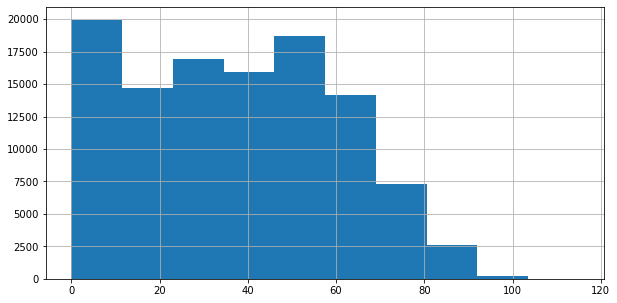

In [70]:
## hist plot of age wrt no-show
df['Age'].hist(figsize=(10, 5));

__Observation:__ Age is clearly a right skewed one. Applying transforms? Log ?

In [71]:
def getProbOfNoShow(col, target, df, forGraph=True):
    crosstab = pd.crosstab(index = df[col], columns = df[target])
    crosstab.columns = pd.Index(list(crosstab.columns))
    crosstab = crosstab.reset_index() 
    crosstab['TotalCount'] = crosstab['Yes'] + crosstab['No']
    crosstab['probNoShowUp'] = crosstab['Yes'] / crosstab['TotalCount']
    
    print(crosstab.head())
    if forGraph:
        return crosstab[[col, 'probNoShowUp']]
    else:
        return crosstab[[col, 'TotalCount', 'probNoShowUp']]

In [72]:
data = getProbOfNoShow('Age', 'No-show', df)

   Age    No  Yes  TotalCount  probNoShowUp
0    0  2901  639        3540      0.180508
1    1  1858  415        2273      0.182578
2    2  1366  252        1618      0.155748
3    3  1236  277        1513      0.183080
4    4  1017  282        1299      0.217090


In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

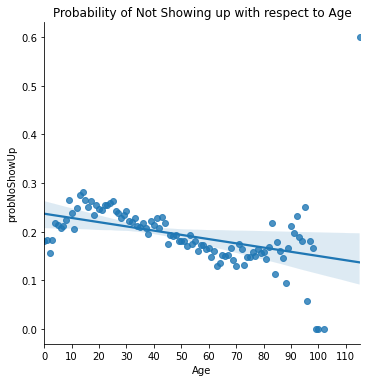

In [80]:
sns.lmplot(data = data, x = 'Age', y = 'probNoShowUp', fit_reg = True)
plt.xticks(np.arange(np.min(df['Age']), np.max(df['Age']), 10))
plt.title('Probability of Not Showing up with respect to Age')
plt.show()

In [81]:
## bining the age column based on above plot

bins = list(np.arange(np.min(df['Age']), np.max(df['Age'])+20, 20))
print(bins)

[0, 20, 40, 60, 80, 100, 120]


In [82]:
labels = bins[:-1]
print(labels)
df['Age_binned'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

[0, 20, 40, 60, 80, 100]


In [83]:
df.loc[df.Age > 100, ['Age','Age_binned']]

,Age,Age_binned
58014,102,100
63912,115,100
63915,115,100
68127,115,100
76284,115,100
90372,102,100
97666,115,100


In [84]:
## drop the age column
df = df.drop(['Age'], axis=1)

### Analysing Categorical Columns

In [85]:
df.describe(include='category')

,PatientId,Gender,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicapped,SMS_received,No-show,Age_binned
count,1.105270e+05,110527,110527,110527,110527,110527,110527,110527,110527,110527,110527
unique,6.229900e+04,2,81,2,2,2,2,5,2,2,6
top,8.221459e+14,F,JARDIM CAMBURI,0,0,0,0,0,0,No,0
freq,8.800000e+01,71840,7717,99666,88726,102584,107167,108286,75045,88208,31849


In [86]:
## custom Function for Bar Plots

def barplot(column,df):
    bar_plot1 = sns.countplot(x=column, data=df)
    
    total = len(df[column])
    for p in bar_plot1.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        height = p.get_height()
        bar_plot1.text(p.get_x()+ p.get_width()/2, height + 400, percentage, ha="center")

#### Univariate Analysis on Categorical Columns

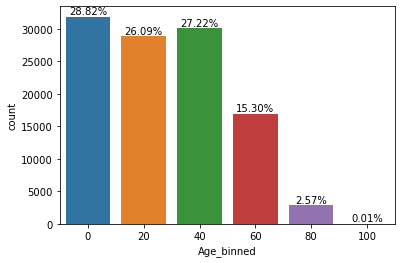

In [87]:
barplot("Age_binned",df)

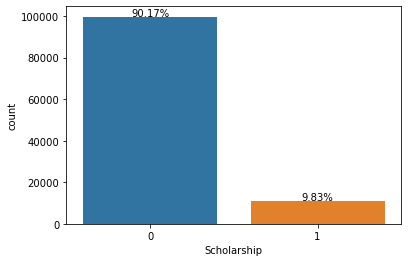

In [88]:
barplot("Scholarship",df)

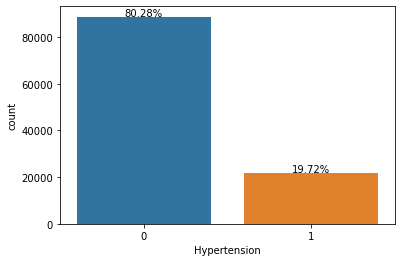

In [89]:
barplot("Hypertension",df)

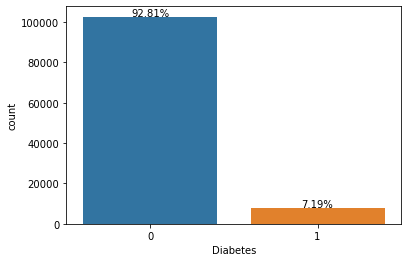

In [90]:
barplot("Diabetes",df)

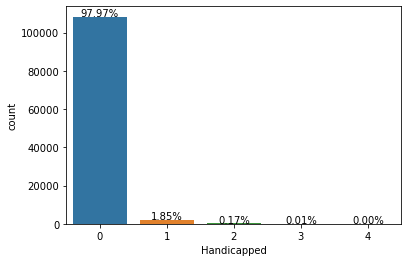

In [91]:
barplot("Handicapped",df)

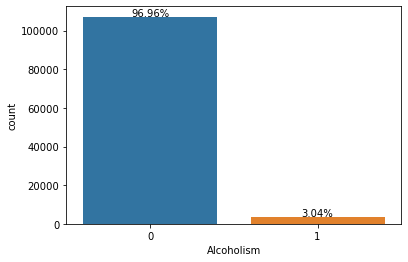

In [92]:
barplot("Alcoholism",df)

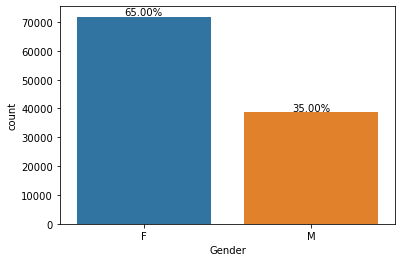

In [93]:
barplot("Gender",df)

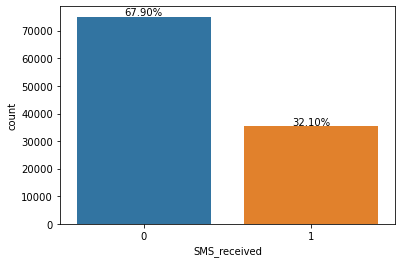

In [94]:
barplot("SMS_received",df)

__Observation__: Using Univariate plots on categorical columns, it is very difficult to find out which attribute is related to the target or not. 

From the above plots, few things can be inferred though
- Handicapped attribute can be merged to binary as other levels have less representation and also no proper information shared by the client on other levels.

- Chi-square test of independence and Bivariate plots can be meaningful 

#### Binning of Handicapped attrribute

In [95]:
df['Handicapped']=df['Handicapped'].astype('int')
df.loc[df.Handicapped > 1, 'Handicapped'] = 1
df['Handicapped']=df['Handicapped'].astype('category')

In [96]:
df['Handicapped'].value_counts()

0    108286
1      2241
Name: Handicapped, dtype: int64

 Performing Chi-Square test of independence

In [97]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

## conda install -c anaconda statsmodels
import statsmodels.api as sm

In [98]:
cat_cols = df.select_dtypes('category').columns
cat_cols

Index(['PatientId', 'Gender', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicapped', 'SMS_received', 'No-show',
       'Age_binned'],
      dtype='object')

In [99]:
# Adding formula for chi-square

In [102]:
def find_chi2_independence(cat_col, target, df, alpha=0.05):
    data = df[[target, cat_col]]
    tab = sm.stats.Table.from_data(data)
    tab = tab.table_orig.to_numpy()
    print(f"---------------{target} Vs {cat_col} Chi Square Test of Independence -------------------")
    print(f"\n Contingency table :\n")
    print(tab)
    
    stat, p, dof, expected = chi2_contingency(tab)
    print(f"\n Expected table :\n")
    print(expected)
    
    print(f"The p value returned = {p} and degrees of freedom returned = {dof}")
    
    # interpret p-value
    print('significance(alpha) = %.3f' % (alpha))

    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)') 

In [103]:
for col in cat_cols:
    find_chi2_independence(col, 'No-show', df)

---------------No-show Vs PatientId Chi Square Test of Independence -------------------

 Contingency table :

[[1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]

 Expected table :

[[0.79806744 0.79806744 0.79806744 ... 0.79806744 0.79806744 0.79806744]
 [0.20193256 0.20193256 0.20193256 ... 0.20193256 0.20193256 0.20193256]]
The p value returned = 4.498875155354318e-49 and degrees of freedom returned = 62298
significance(alpha) = 0.050
Dependent (reject H0)
---------------No-show Vs Gender Chi Square Test of Independence -------------------

 Contingency table :

[[57246 30962]
 [14594  7725]]

 Expected table :

[[57333.16492803 30874.83507197]
 [14506.83507197  7812.16492803]]
The p value returned = 0.17338418189785987 and degrees of freedom returned = 1
significance(alpha) = 0.050
Independent (fail to reject H0)
---------------No-show Vs Neighbourhood Chi Square Test of Independence -------------------

 Contingency table :

[[   7 1741  221  220  332 1523  665  254 2223 1974 2631  254  689 1

__Observation__: 
- PatientId, Neighbourhood, Scholarship, Hypertension, Diabetes, SMS_received, Age_binned attributes tend to influence the target

- Gender & Alcoholism doesn't have any dependency with target

Let us also run probabilistic approach for categorical columns

### Probabilistic Analysis of Categorical columns on No show

In [104]:
def probStatusCategorical(col_list):
    rows = []
    for item in col_list:
        for level in df[item].unique():
            row = {'Condition': item}
            ## Finding count of rows with that level in categorical column
            total = len(df[df[item] == level])
            ## Finding count of rows where level and Yes in No-show match
            n = len(df[(df[item] == level) & (df['No-show'] == 'Yes')])
            row.update({'Level': level, 'Probability': n / total})
            rows.append(row)
    return pd.DataFrame(rows)

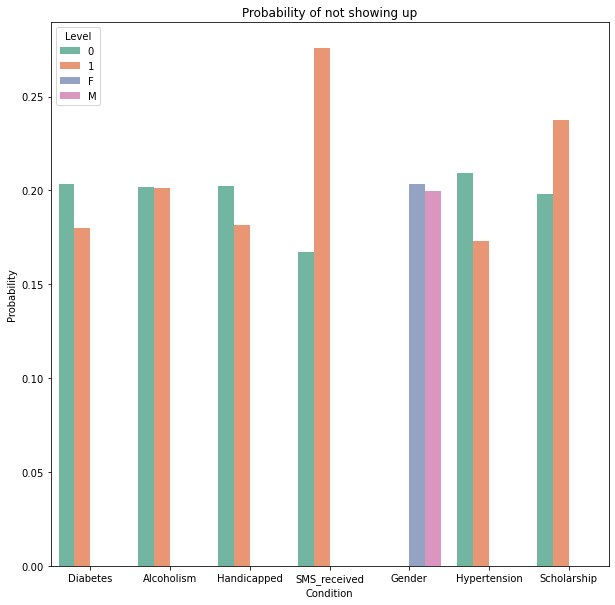

In [105]:
plt.figure(figsize=(10,10))
sns.barplot(data = probStatusCategorical(['Diabetes', 'Alcoholism', 'Handicapped', 
                                          'SMS_received', 'Gender', 'Hypertension','Scholarship']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.title('Probability of not showing up')
plt.ylabel('Probability')
plt.show()

__Observation:__ 
- 1) Clearly SMS received status and Scholarship Status drive no-show up's
- 2) Gender and Alcoholism are not contributing to the target (No-show class)

### Dealing High Cardinal Categorical Attributes

- We have two attributes namely PatientID and Neighbourhood that have high cardinality. Also Chi-square test of independence shows that these two columns influence target variable.

- But given some limitations with known techniques under ML till date, we would like to handle these variables using Categorical Embeddings. Hence proceeding further we will not be using these variables in our analysis

- Before we step in to DL module, we can still use pandas techniques like crosstab to find the probabilistic nature of these variables on No-show attribute

In [106]:
patient_df = getProbOfNoShow('PatientId', 'No-show', df, forGraph=False)
patient_df.to_csv('patientID_VS_NoShow.csv', index=False)

      PatientId  No  Yes  TotalCount  probNoShowUp
0   39217.84439   1    0           1           0.0
1   43741.75652   1    0           1           0.0
2   93779.52927   1    0           1           0.0
3  141724.16655   1    0           1           0.0
4  537615.28476   1    0           1           0.0


In [107]:
neigh_df = getProbOfNoShow('Neighbourhood', 'No-show', df, forGraph=False)
neigh_df.to_csv('Neighbourhood_VS_NoShow.csv', index=False)

         Neighbourhood    No  Yes  TotalCount  probNoShowUp
0            AEROPORTO     7    1           8      0.125000
1           ANDORINHAS  1741  521        2262      0.230327
2      ANTÔNIO HONÓRIO   221   50         271      0.184502
3  ARIOVALDO FAVALESSA   220   62         282      0.219858
4       BARRO VERMELHO   332   91         423      0.215130


In [108]:
### Dropping off the above columns
df = df.drop(['Neighbourhood','PatientId','Gender','Alcoholism'], axis=1)

In [109]:
df.columns

Index(['ScheduledDay', 'AppointmentDay', 'Scholarship', 'Hypertension',
       'Diabetes', 'Handicapped', 'SMS_received', 'No-show', 'Age_binned'],
      dtype='object')

## Feature Engineering

### Generating new features from scheduled and appointment date features

In [113]:
df['Scheduled_DateTime'] = pd.to_datetime(df['ScheduledDay'])
df['Scheduled_date'] = df['Scheduled_DateTime'].dt.date
df['Scheduled_month']=df['Scheduled_DateTime'].dt.month
df['Scheduled_hour'] = df['Scheduled_DateTime'].dt.hour
df['Scheduled_weekday']=df['Scheduled_DateTime'].dt.weekday


In [114]:
df['Appointment_DateTime'] = pd.to_datetime(df['AppointmentDay'])
df['Appointment_date'] = df['Appointment_DateTime'].dt.date
df['Appointment_month']=df['Appointment_DateTime'].dt.month
df['Appointment_hour'] = df['Appointment_DateTime'].dt.hour
df['Appointment_weekday']=df['Appointment_DateTime'].dt.weekday

In [115]:
np.min(df['Scheduled_date'])

datetime.date(2015, 11, 10)

In [116]:
np.max(df['Scheduled_date'])

datetime.date(2016, 6, 8)

In [117]:
df[['Appointment_DateTime', 'Appointment_date', 'Appointment_month', 'Appointment_hour', 'Appointment_weekday']]

,Appointment_DateTime,Appointment_date,Appointment_month,Appointment_hour,Appointment_weekday
0,2016-04-29 00:00:00+00:00,2016-04-29,4,0,4
1,2016-04-29 00:00:00+00:00,2016-04-29,4,0,4
2,2016-04-29 00:00:00+00:00,2016-04-29,4,0,4
3,2016-04-29 00:00:00+00:00,2016-04-29,4,0,4
4,2016-04-29 00:00:00+00:00,2016-04-29,4,0,4
...,...,...,...,...,...
110522,2016-06-07 00:00:00+00:00,2016-06-07,6,0,1
110523,2016-06-07 00:00:00+00:00,2016-06-07,6,0,1
110524,2016-06-07 00:00:00+00:00,2016-06-07,6,0,1
110525,2016-06-07 00:00:00+00:00,2016-06-07,6,0,1


### Creating 'number of days to appointment' 

This feature may have an impact on our target feature as we tend to forget,hence retrieving new feature from scheduled date and appointment date

In [118]:
fn = lambda row: (row.Appointment_date - row.Scheduled_date).days
df['num_of_days'] = df.apply (fn, axis=1)

In [119]:
df.num_of_days.describe()

count    110527.000000
mean         10.183702
std          15.254996
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: num_of_days, dtype: float64

__Observation__: We can see some negative values indicating there might be some outliers in the data as appointment date cannot happen before the scheduled date

In [120]:
df.loc[df.num_of_days < 0, ['num_of_days']] = 0

In [121]:
df = df.drop(['ScheduledDay','Scheduled_DateTime','Scheduled_date'], axis=1)
df = df.drop(['AppointmentDay','Appointment_DateTime','Appointment_date'], axis=1)

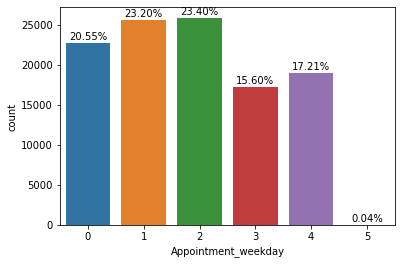

In [122]:
#0:MONDAY 1:TUESDAY 2:WEDNESDAY 3:THURSDAY 4:FRIDAY 5:SATURDAY
barplot("Appointment_weekday",df)

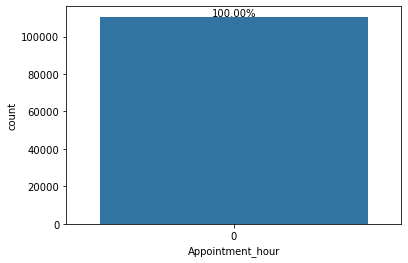

In [123]:
barplot("Appointment_hour",df)

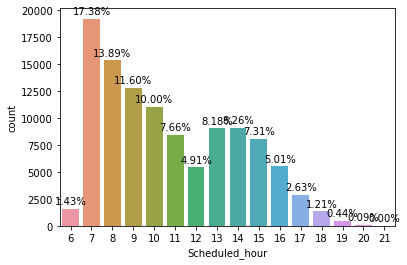

In [124]:
barplot("Scheduled_hour",df)

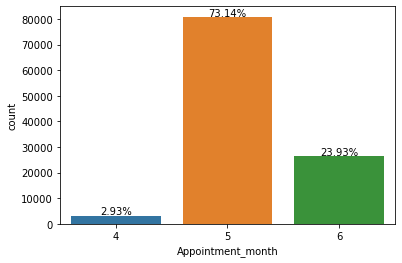

In [125]:
barplot("Appointment_month",df)

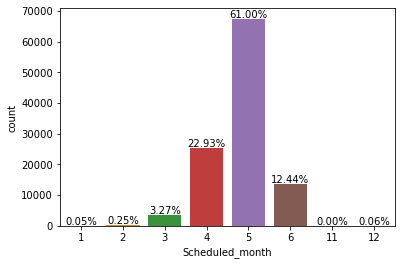

In [126]:
barplot("Scheduled_month",df)

__Observation:__ appointment hour has zero variance. So can be deleted

In [186]:
## droping the Appointment_hour
df = df.drop(['Appointment_hour'], axis=1)

### Typecasting newly created features

In [129]:
df.dtypes

Scholarship            category
Hypertension           category
Diabetes               category
Handicapped            category
SMS_received           category
No-show                category
Age_binned             category
Scheduled_month           int64
Scheduled_hour            int64
Scheduled_weekday         int64
Appointment_month         int64
Appointment_weekday       int64
num_of_days               int64
dtype: object

In [131]:
## converting the columns into categorical type only
for col in ['Scheduled_month', 'Scheduled_weekday', 'Appointment_month', 'Appointment_weekday']:
    df[col] = df[col].astype('category')

In [133]:
## check the data type of teh data set
df.dtypes

Scholarship            category
Hypertension           category
Diabetes               category
Handicapped            category
SMS_received           category
No-show                category
Age_binned             category
Scheduled_month        category
Scheduled_hour            int64
Scheduled_weekday      category
Appointment_month      category
Appointment_weekday    category
num_of_days               int64
dtype: object

### Effect of num_days on No-show attribute

In [134]:
data = getProbOfNoShow('num_of_days', 'No-show', df)

   num_of_days     No   Yes  TotalCount  probNoShowUp
0            0  36771  1797       38568      0.046593
1            1   4100  1113        5213      0.213505
2            2   5123  1602        6725      0.238216
3            3   2093   644        2737      0.235294
4            4   4059  1231        5290      0.232703


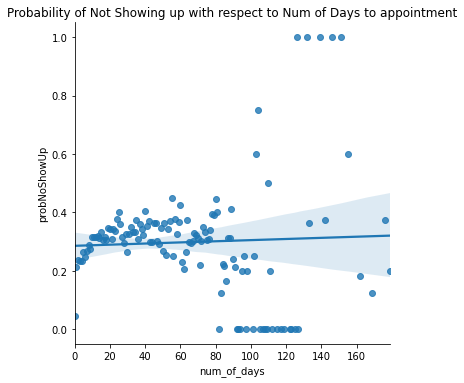

In [135]:
sns.lmplot(data = data, x = 'num_of_days', y = 'probNoShowUp', fit_reg = True)
# plt.xticks(np.arange(np.min(df['num_days']), np.max(df['num_days']), 10))
plt.title('Probability of Not Showing up with respect to Num of Days to appointment')
plt.show()

__Observation:__ Num of days prior to appointment has no clear pattern in it.

### Effect of Scheduled_hour on No-show attribute

In [136]:
data = getProbOfNoShow('Scheduled_hour', 'No-show', df)

   Scheduled_hour     No   Yes  TotalCount  probNoShowUp
0               6   1275   303        1578      0.192015
1               7  16302  2911       19213      0.151512
2               8  12545  2804       15349      0.182683
3               9  10297  2526       12823      0.196990
4              10   8616  2440       11056      0.220695


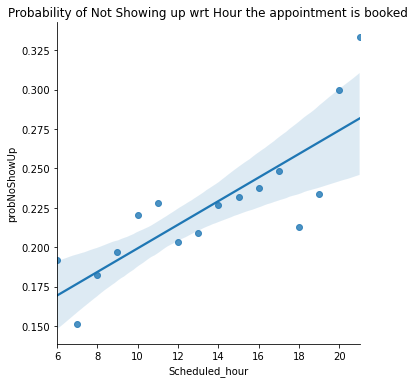

In [137]:
sns.lmplot(data = data, x = 'Scheduled_hour', y = 'probNoShowUp', fit_reg = True)
# plt.xticks(np.arange(np.min(df['num_days']), np.max(df['num_days']), 10))
plt.title('Probability of Not Showing up wrt Hour the appointment is booked')
plt.show()

__Observation__: There is clear trend in above graph, showcasing the effect of scheduled hour on no-show up. We can bin Scheduled hour with bin size of 2 hours

In [138]:
#Binning of Scheduled_time
def get_session_of_day(x):
    if x < 8:
        return 'EarlyMorning'
    elif (x >= 8) and (x < 12 ):
        return 'Morning'
    elif (x >= 12) and (x < 16):
        return'Noon'
    elif (x >= 16) and (x < 20) :
        return 'Eve'
    elif (x >= 20) and (x < 24):
        return'Night'

In [139]:
df['Scheduled_session_of_day'] = df['Scheduled_hour'].apply(get_session_of_day)

In [140]:
df=df.drop('Scheduled_hour',axis=1)

In [141]:
df['Scheduled_session_of_day']=df['Scheduled_session_of_day'].astype('category')
df.dtypes

Scholarship                 category
Hypertension                category
Diabetes                    category
Handicapped                 category
SMS_received                category
No-show                     category
Age_binned                  category
Scheduled_month             category
Scheduled_weekday           category
Appointment_month           category
Appointment_weekday         category
num_of_days                    int64
Scheduled_session_of_day    category
dtype: object

### Performing Chisquare test of independence on newly added categorical columns

In [142]:
for col in ['Scheduled_month', 'Scheduled_weekday', 'Appointment_month', 'Appointment_weekday', 'Scheduled_session_of_day']:
    find_chi2_independence(col, 'No-show', df)

---------------No-show Vs Scheduled_month Chi Square Test of Independence -------------------

 Contingency table :

[[   42   199  2418 17490 55652 12364     1    42]
 [   18    82  1196  7849 11769  1386     0    19]]

 Expected table :

[[4.78840464e+01 2.24256951e+02 2.88421573e+03 2.02222309e+04
  5.38065049e+04 1.09734273e+04 7.98067441e-01 4.86821139e+01]
 [1.21159536e+01 5.67430492e+01 7.29784270e+02 5.11676912e+03
  1.36144951e+04 2.77657269e+03 2.01932559e-01 1.23178861e+01]]
The p value returned = 0.0 and degrees of freedom returned = 7
significance(alpha) = 0.050
Dependent (reject H0)
---------------No-show Vs Scheduled_weekday Chi Square Test of Independence -------------------

 Contingency table :

[[18524 20877 19383 14373 15028    23]
 [ 4561  5291  4879  3700  3887     1]]

 Expected table :

[[1.84233869e+04 2.08838288e+04 1.93627122e+04 1.44234729e+04
  1.50954456e+04 1.91536186e+01]
 [4.66161314e+03 5.28417122e+03 4.89928776e+03 3.64952715e+03
  3.81955436e+03 4.84

__Observation:__ We see most of the newly engineered features show some relation w.r.t to target

### Probabilistic Analysis of newly created features

##### Scheduled Month and Appointment Month

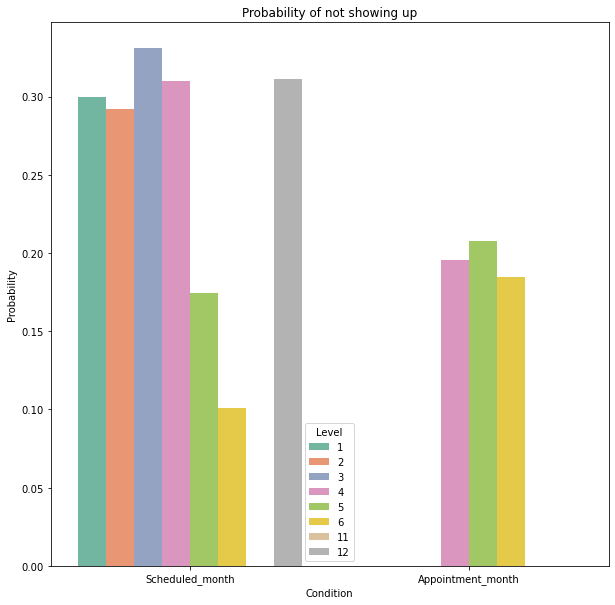

In [143]:
plt.figure(figsize=(10,10))
sns.barplot(data = probStatusCategorical(['Scheduled_month', 'Appointment_month']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.title('Probability of not showing up')
plt.ylabel('Probability')
plt.show()

__Observation__: Suprised to see that appointments are allowed/booked for only three months

##### Scheduled Weekday and Appointment Weekday

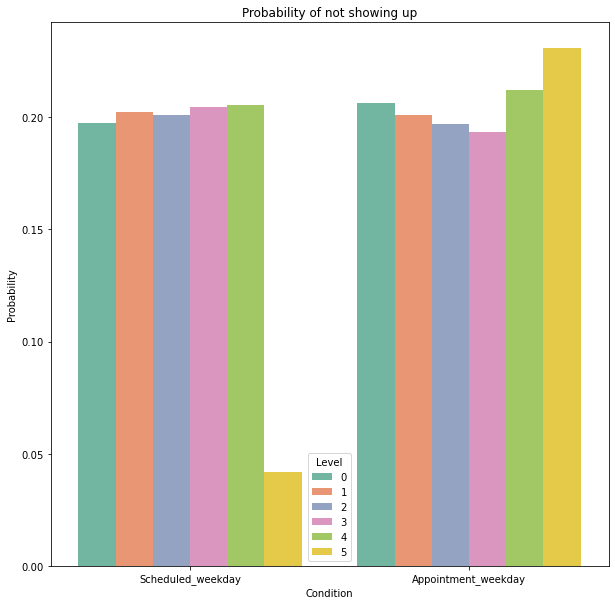

In [144]:
plt.figure(figsize=(10,10))
sns.barplot(data = probStatusCategorical(['Scheduled_weekday', 'Appointment_weekday']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.title('Probability of not showing up')
plt.ylabel('Probability')
plt.show()

__Observation__: Weekday seems to have similar/equal pattern on no show ups. 

Some interesting insights are
- Significantly less people called/scheduled for an appointment on Saturday. 
- More people tend to not show up on Saturday

## Checking  target feature distribution

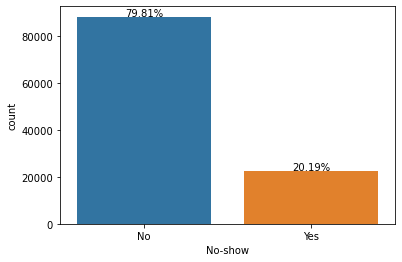

In [145]:
barplot("No-show",df)

In [146]:
print("The count distribution target classes is as below:")

df['No-show'].value_counts()

The count distribution target classes is as below:


No     88208
Yes    22319
Name: No-show, dtype: int64

In [147]:
print("The percentage distribution target classes is as below:")

df['No-show'].value_counts('Yes')

The percentage distribution target classes is as below:


No     0.798067
Yes    0.201933
Name: No-show, dtype: float64

### Replacing Yes/No in the target column with 1/0

In [148]:
df['No-show'].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

In [149]:
df['No-show'] = df['No-show'].replace(to_replace=['No', 'Yes'], value=[0, 1])
df['No-show'].value_counts()

0    88208
1    22319
Name: No-show, dtype: int64

# Split the data into train and test

In [150]:
y=df["No-show"]
X=df.drop('No-show', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20,random_state=123, stratify=y)

In [151]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(88421, 12)
(22106, 12)
(88421,)
(22106,)


## Split the attributes into numerical and categorical types

In [152]:
num_attr=X_train.select_dtypes(['int64']).columns
num_attr

Index(['num_of_days'], dtype='object')

In [153]:
cat_attr = X_train.select_dtypes('category').columns
cat_attr

Index(['Scholarship', 'Hypertension', 'Diabetes', 'Handicapped',
       'SMS_received', 'Age_binned', 'Scheduled_month', 'Scheduled_weekday',
       'Appointment_month', 'Appointment_weekday', 'Scheduled_session_of_day'],
      dtype='object')

# Preparation for Model buillding

## Imputing missing values with median for numerical attributes

In [154]:
imputer = SimpleImputer(strategy='median')

imputer = imputer.fit(X_train[num_attr])

X_train[num_attr] = imputer.transform(X_train[num_attr])
X_val[num_attr] = imputer.transform(X_val[num_attr])

In [155]:
print(X_train.isnull().sum())
print(X_val.isnull().sum())

Scholarship                 0
Hypertension                0
Diabetes                    0
Handicapped                 0
SMS_received                0
Age_binned                  0
Scheduled_month             0
Scheduled_weekday           0
Appointment_month           0
Appointment_weekday         0
num_of_days                 0
Scheduled_session_of_day    0
dtype: int64
Scholarship                 0
Hypertension                0
Diabetes                    0
Handicapped                 0
SMS_received                0
Age_binned                  0
Scheduled_month             0
Scheduled_weekday           0
Appointment_month           0
Appointment_weekday         0
num_of_days                 0
Scheduled_session_of_day    0
dtype: int64


## Imputing missing values with mode for categorical attributes

In [156]:
imputer = SimpleImputer(strategy='most_frequent')

imputer = imputer.fit(X_train[cat_attr])

X_train[cat_attr] = imputer.transform(X_train[cat_attr])
X_val[cat_attr] = imputer.transform(X_val[cat_attr])

### Standardizing the numerical attributes and One-hot encoding categorical attributes 

In [157]:
# DataFrameMapper, a class for mapping pandas data frame columns to different sklearn transformations
mapper = DataFrameMapper(
  [([continuous_col], StandardScaler()) for continuous_col in num_attr] +
  [([categorical_col], OneHotEncoder(handle_unknown='error')) for categorical_col in cat_attr]
, df_out=True)

In [158]:
print(type(mapper))

<class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>


In [187]:
#mapper.fit(X_train)

X_train_final = mapper.transform(X_train)
X_val_final = mapper.transform(X_val)

In [163]:
X_train_final.columns

Index(['num_of_days', 'Scholarship_x0_0', 'Scholarship_x0_1',
       'Hypertension_x0_0', 'Hypertension_x0_1', 'Diabetes_x0_0',
       'Diabetes_x0_1', 'Handicapped_x0_0', 'Handicapped_x0_1',
       'SMS_received_x0_0', 'SMS_received_x0_1', 'Age_binned_x0_0',
       'Age_binned_x0_20', 'Age_binned_x0_40', 'Age_binned_x0_60',
       'Age_binned_x0_80', 'Age_binned_x0_100', 'Scheduled_month_x0_1',
       'Scheduled_month_x0_2', 'Scheduled_month_x0_3', 'Scheduled_month_x0_4',
       'Scheduled_month_x0_5', 'Scheduled_month_x0_6', 'Scheduled_month_x0_11',
       'Scheduled_month_x0_12', 'Scheduled_weekday_x0_0',
       'Scheduled_weekday_x0_1', 'Scheduled_weekday_x0_2',
       'Scheduled_weekday_x0_3', 'Scheduled_weekday_x0_4',
       'Scheduled_weekday_x0_5', 'Appointment_month_x0_4',
       'Appointment_month_x0_5', 'Appointment_month_x0_6',
       'Appointment_weekday_x0_0', 'Appointment_weekday_x0_1',
       'Appointment_weekday_x0_2', 'Appointment_weekday_x0_3',
       'Appointment_we

In [164]:
X_train_final.head()

,num_of_days,Scholarship_x0_0,Scholarship_x0_1,Hypertension_x0_0,Hypertension_x0_1,Diabetes_x0_0,Diabetes_x0_1,Handicapped_x0_0,Handicapped_x0_1,SMS_received_x0_0,...,Appointment_weekday_x0_1,Appointment_weekday_x0_2,Appointment_weekday_x0_3,Appointment_weekday_x0_4,Appointment_weekday_x0_5,Scheduled_session_of_day_x0_EarlyMorning,Scheduled_session_of_day_x0_Eve,Scheduled_session_of_day_x0_Morning,Scheduled_session_of_day_x0_Night,Scheduled_session_of_day_x0_Noon
29694,-0.207606,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
43957,-0.142118,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
83223,-0.207606,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
66767,-0.666023,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32398,0.447275,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [165]:
X_val_final.head()

,num_of_days,Scholarship_x0_0,Scholarship_x0_1,Hypertension_x0_0,Hypertension_x0_1,Diabetes_x0_0,Diabetes_x0_1,Handicapped_x0_0,Handicapped_x0_1,SMS_received_x0_0,...,Appointment_weekday_x0_1,Appointment_weekday_x0_2,Appointment_weekday_x0_3,Appointment_weekday_x0_4,Appointment_weekday_x0_5,Scheduled_session_of_day_x0_EarlyMorning,Scheduled_session_of_day_x0_Eve,Scheduled_session_of_day_x0_Morning,Scheduled_session_of_day_x0_Night,Scheduled_session_of_day_x0_Noon
98633,0.840204,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
56036,-0.404070,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
267,-0.666023,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
82513,0.709228,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20923,-0.600534,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Defining Error Metrics

In [166]:
def get_CR_CM(train_actual,train_predicted,test_actual,test_predicted):
    print('''
         ========================================
           CLASSIFICATION REPORT FOR TRAIN DATA
         ========================================
        ''')
    print(classification_report(train_actual, train_predicted, digits=4))

    print('''
             =============================================
               CLASSIFICATION REPORT FOR VALIDATION DATA
             =============================================
            ''')
    print(classification_report(test_actual, test_predicted, digits=4))

    print('''
             ========================================
               Confusion Matrix FOR TRAIN DATA
             ========================================
            ''')
    print(confusion_matrix(train_actual, train_predicted))

    print('''
             =============================================
               Confusion matrix FOR VALIDATION DATA
             =============================================
            ''')
    print(confusion_matrix(test_actual, test_predicted))
    

In [167]:
scores = pd.DataFrame(columns=['Model','Train_Accuracy','Train_Recall','Train_Precision','Train_F1_Score','Test_Accuracy','Test_Recall','Test_Precision','Test_F1_Score'])

def get_metrics(train_actual,train_predicted,test_actual,test_predicted,model_description,dataframe):
    get_CR_CM(train_actual,train_predicted,test_actual,test_predicted)
    train_accuracy = accuracy_score(train_actual,train_predicted)
    train_recall   = recall_score(train_actual,train_predicted)
    train_precision= precision_score(train_actual,train_predicted)
    train_f1score  = f1_score(train_actual,train_predicted)
    test_accuracy = accuracy_score(test_actual,test_predicted)
    test_recall   = recall_score(test_actual,test_predicted)
    test_precision= precision_score(test_actual,test_predicted)
    test_f1score  = f1_score(test_actual,test_predicted)
    dataframe = dataframe.append(pd.Series([model_description, train_accuracy,train_recall,train_precision,train_f1score,
                                            test_accuracy,test_recall,test_precision,test_f1score],
                                           index=scores.columns ), ignore_index=True)
    return(dataframe)

# MODEL BUILDING

### 1. Logistic Regression

In [168]:
log_mod = LogisticRegression(random_state=123)

In [188]:
log_mod.fit(X_train_final, y_train)

In [170]:
y_pred_train = log_mod.predict(X_train_final)
y_pred_val = log_mod.predict(X_val_final)

##### Evaluating the model performance

In [100]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"LogisticRegression",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.7995    0.9925    0.8856     70566
           1     0.3580    0.0165    0.0316     17855

    accuracy                         0.7954     88421
   macro avg     0.5788    0.5045    0.4586     88421
weighted avg     0.7104    0.7954    0.7132     88421


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.7991    0.9917    0.8850     17642
           1     0.3048    0.0143    0.0274      4464

    accuracy                         0.7944     22106
   macro avg     0.5519    0.5030    0.4562     22106
weighted avg     0.6992    0.7944    0.7118     22106


               Confusion Matrix FOR TRAIN DATA
            
[[70037   529]
 [17560   295]]

               Confusion matrix FOR VALIDATION DATA
            
[[17496   146]
 [ 4400    64]]


,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795422,0.016522,0.35801,0.031586,0.794354,0.014337,0.304762,0.027386


## _Handling Imbalanced Data_

### Class Weights of loss function

The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))


### 2. Logistic Regression with class_weight='balanced'

In [101]:
log_mod = LogisticRegression(class_weight='balanced', random_state=123)

In [102]:
log_mod.fit(X_train_final, y_train)

LogisticRegression(class_weight='balanced', random_state=123)

In [103]:
y_pred_train = log_mod.predict(X_train_final)
y_pred_val = log_mod.predict(X_val_final)

##### Evaluating the model performance

In [104]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"LogisticRegression_Balanced",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8698    0.6806    0.7637     70566
           1     0.3212    0.5974    0.4178     17855

    accuracy                         0.6638     88421
   macro avg     0.5955    0.6390    0.5907     88421
weighted avg     0.7590    0.6638    0.6938     88421


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.8709    0.6732    0.7594     17642
           1     0.3192    0.6055    0.4180      4464

    accuracy                         0.6595     22106
   macro avg     0.5950    0.6394    0.5887     22106
weighted avg     0.7595    0.6595    0.6905     22106


               Confusion Matrix FOR TRAIN DATA
            
[[48027 22539]
 [ 7189 10666]]

               Confusion matrix FOR VALIDATION DATA
            
[[11877  5765]
 [ 1761  2703]]


,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795422,0.016522,0.358010,0.031586,0.794354,0.014337,0.304762,0.027386
1,LogisticRegression_Balanced,0.663790,0.597368,0.321217,0.417783,0.659549,0.605511,0.319202,0.418033


### 3. Decision Tree Classifier

In [105]:
# Create Decision Tree classifer object
clf_dt = DecisionTreeClassifier(random_state=123)

# Train Decision Tree Classifer
clf_dt.fit(X_train_final,y_train)

DecisionTreeClassifier(random_state=123)

In [106]:
y_pred_train = clf_dt.predict(X_train_final)
y_pred_val = clf_dt.predict(X_val_final)

##### Evaluating the model performance

In [107]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"DecisionTree",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8597    0.9819    0.9168     70566
           1     0.8367    0.3670    0.5102     17855

    accuracy                         0.8577     88421
   macro avg     0.8482    0.6744    0.7135     88421
weighted avg     0.8551    0.8577    0.8347     88421


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.8175    0.9197    0.8656     17642
           1     0.3726    0.1884    0.2503      4464

    accuracy                         0.7721     22106
   macro avg     0.5950    0.5541    0.5579     22106
weighted avg     0.7276    0.7721    0.7413     22106


               Confusion Matrix FOR TRAIN DATA
            
[[69287  1279]
 [11303  6552]]

               Confusion matrix FOR VALIDATION DATA
            
[[16226  1416]
 [ 3623   841]]


,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795422,0.016522,0.358010,0.031586,0.794354,0.014337,0.304762,0.027386
1,LogisticRegression_Balanced,0.663790,0.597368,0.321217,0.417783,0.659549,0.605511,0.319202,0.418033
2,DecisionTree,0.857703,0.366956,0.836675,0.510161,0.772053,0.188396,0.372619,0.250260


### 4. Decision Tree with Grid-Search CV - Hyper-parameter Tuning

In [108]:
# set of parameters to test
param_grid = {"class_weight":['balanced', None],
              "criterion": ["gini", "entropy"],
              "max_depth": [3, 5, 6],
              "min_samples_leaf": [2, 5, 10],
               "max_leaf_nodes": [None, 5, 10, 20]
              }

In [109]:
dt = tree.DecisionTreeClassifier(random_state=123)
clf_dt_grid = GridSearchCV(dt, param_grid,cv=5,scoring='recall')
clf_dt_grid.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 6],
                         'max_leaf_nodes': [None, 5, 10, 20],
                         'min_samples_leaf': [2, 5, 10]},
             scoring='recall')

In [110]:
clf_dt_grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 3,
 'max_leaf_nodes': 5,
 'min_samples_leaf': 2}

In [111]:
y_pred_train = clf_dt_grid.predict(X_train_final)
y_pred_val = clf_dt_grid.predict(X_val_final)

In [112]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"DecisionTree_BestParameters",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9535    0.4181    0.5813     70566
           1     0.2856    0.9194    0.4358     17855

    accuracy                         0.5193     88421
   macro avg     0.6196    0.6688    0.5086     88421
weighted avg     0.8186    0.5193    0.5519     88421


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.9530    0.4119    0.5752     17642
           1     0.2835    0.9198    0.4334      4464

    accuracy                         0.5144     22106
   macro avg     0.6183    0.6658    0.5043     22106
weighted avg     0.8178    0.5144    0.5465     22106


               Confusion Matrix FOR TRAIN DATA
            
[[29505 41061]
 [ 1439 16416]]

               Confusion matrix FOR VALIDATION DATA
            
[[ 7266 10376]
 [  358  4106]]


,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795422,0.016522,0.358010,0.031586,0.794354,0.014337,0.304762,0.027386
1,LogisticRegression_Balanced,0.663790,0.597368,0.321217,0.417783,0.659549,0.605511,0.319202,0.418033
2,DecisionTree,0.857703,0.366956,0.836675,0.510161,0.772053,0.188396,0.372619,0.250260
3,DecisionTree_BestParameters,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442


### 5. Decision Tree with RandomizedSearchCV - Hyper-parameter Tuning

In [113]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

clf3_dt = DecisionTreeClassifier(random_state=123, class_weight='balanced') 

In [114]:
max_leaf_nodes = np.random.normal(loc=5, scale=1, size=5).astype(int)
max_leaf_nodes[max_leaf_nodes <1] = 1
print(max_leaf_nodes)
max_depth = np.random.uniform(2,5,4).astype(int)
print(max_depth)
min_samples_split = np.random.uniform(2, 6, 5).astype(int)
print(min_samples_split)

[4 5 6 4 4]
[4 2 4 3]
[5 4 5 3 5]


In [115]:
## Set Up Hyperparameter Distributions

# normally distributed max_leaf_nodes, with mean 5 stddev 1
max_leaf_nodes = np.random.normal(loc=5, scale=1, size=5).astype(int)

# uniform distribution from 2 to 5 
max_depth = np.random.uniform(2,5,4).astype(int)

# uniform distribution from 2 to 6
min_samples_split = np.random.uniform(2, 6, 5).astype(int)

model_params = {
    'max_depth': list(max_depth),
    'max_leaf_nodes': list(max_leaf_nodes),
    'min_samples_split': list(min_samples_split)
}

In [116]:
clf_random = RandomizedSearchCV(estimator=clf3_dt, param_distributions=model_params, n_iter=600, cv=5, scoring='recall', n_jobs=-1)
clf_random.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=123),
                   n_iter=600, n_jobs=-1,
                   param_distributions={'max_depth': [4, 4, 4, 2],
                                        'max_leaf_nodes': [4, 5, 4, 4, 3],
                                        'min_samples_split': [3, 4, 3, 4, 3]},
                   scoring='recall')

In [117]:
print(clf_random.best_score_, clf_random.best_params_)

0.8983478017362083 {'min_samples_split': 3, 'max_leaf_nodes': 4, 'max_depth': 4}


In [118]:
clf_dt_random = clf_random.best_estimator_
print(clf_dt_random)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, max_leaf_nodes=4,
                       min_samples_split=3, random_state=123)


In [119]:
y_pred_train = clf_dt_random.predict(X_train_final)
y_pred_val = clf_dt_random.predict(X_val_final)

In [120]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"DecisionTree_RandomizedSearch",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9535    0.4181    0.5813     70566
           1     0.2856    0.9194    0.4358     17855

    accuracy                         0.5193     88421
   macro avg     0.6196    0.6688    0.5086     88421
weighted avg     0.8186    0.5193    0.5519     88421


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.9530    0.4119    0.5752     17642
           1     0.2835    0.9198    0.4334      4464

    accuracy                         0.5144     22106
   macro avg     0.6183    0.6658    0.5043     22106
weighted avg     0.8178    0.5144    0.5465     22106


               Confusion Matrix FOR TRAIN DATA
            
[[29505 41061]
 [ 1439 16416]]

               Confusion matrix FOR VALIDATION DATA
            
[[ 7266 10376]
 [  358  4106]]


,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795422,0.016522,0.358010,0.031586,0.794354,0.014337,0.304762,0.027386
1,LogisticRegression_Balanced,0.663790,0.597368,0.321217,0.417783,0.659549,0.605511,0.319202,0.418033
2,DecisionTree,0.857703,0.366956,0.836675,0.510161,0.772053,0.188396,0.372619,0.250260
3,DecisionTree_BestParameters,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
4,DecisionTree_RandomizedSearch,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442


# 6. AdaBoostClassifier

In [171]:
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(criterion="gini",class_weight='balanced'),n_estimators=100,learning_rate = 0.4,random_state=123)
clf_ada.fit(X_train_final, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'),
                   learning_rate=0.4, n_estimators=100, random_state=123)

In [122]:
y_pred_train = clf_ada.predict(X_train_final)
y_pred_val = clf_ada.predict(X_val_final)

In [123]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"Adaboost",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9501    0.7550    0.8414     70566
           1     0.4654    0.8432    0.5998     17855

    accuracy                         0.7728     88421
   macro avg     0.7078    0.7991    0.7206     88421
weighted avg     0.8522    0.7728    0.7926     88421


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.8535    0.7114    0.7760     17642
           1     0.3121    0.5175    0.3893      4464

    accuracy                         0.6722     22106
   macro avg     0.5828    0.6144    0.5827     22106
weighted avg     0.7442    0.6722    0.6979     22106


               Confusion Matrix FOR TRAIN DATA
            
[[53275 17291]
 [ 2800 15055]]

               Confusion matrix FOR VALIDATION DATA
            
[[12550  5092]
 [ 2154  2310]]


,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795422,0.016522,0.358010,0.031586,0.794354,0.014337,0.304762,0.027386
1,LogisticRegression_Balanced,0.663790,0.597368,0.321217,0.417783,0.659549,0.605511,0.319202,0.418033
2,DecisionTree,0.857703,0.366956,0.836675,0.510161,0.772053,0.188396,0.372619,0.250260
3,DecisionTree_BestParameters,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
4,DecisionTree_RandomizedSearch,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
5,Adaboost,0.772780,0.843181,0.465436,0.599789,0.672216,0.517473,0.312078,0.389348


### 7. Adaboost Classifier with Grid Search CV

In [124]:
# GridSearchCV
param_grid = {'n_estimators' : [100, 200, 300],
              'learning_rate' : [0.2, 0.3, 0.4]}

clf_grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), param_grid, scoring='recall',n_jobs=-1)


In [125]:
clf_grid_ada.fit(X_train_final, y_train)

GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.3, 0.4],
                         'n_estimators': [100, 200, 300]},
             scoring='recall')

In [126]:
best_ada_model = clf_grid_ada.best_estimator_
print(best_ada_model)
print (clf_grid_ada.best_score_, clf_grid_ada.best_params_) 

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.4,
                   n_estimators=200)
0.1841500980117614 {'learning_rate': 0.4, 'n_estimators': 200}


In [127]:
y_pred_train = best_ada_model.predict(X_train_final)
y_pred_val = best_ada_model.predict(X_val_final)

In [128]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"Adaboost_BestParameters",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8646    0.9742    0.9162     70566
           1     0.7959    0.3972    0.5299     17855

    accuracy                         0.8577     88421
   macro avg     0.8303    0.6857    0.7230     88421
weighted avg     0.8507    0.8577    0.8382     88421


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.8174    0.9223    0.8667     17642
           1     0.3770    0.1857    0.2488      4464

    accuracy                         0.7736     22106
   macro avg     0.5972    0.5540    0.5578     22106
weighted avg     0.7285    0.7736    0.7419     22106


               Confusion Matrix FOR TRAIN DATA
            
[[68747  1819]
 [10763  7092]]

               Confusion matrix FOR VALIDATION DATA
            
[[16272  1370]
 [ 3635   829]]


,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795422,0.016522,0.358010,0.031586,0.794354,0.014337,0.304762,0.027386
1,LogisticRegression_Balanced,0.663790,0.597368,0.321217,0.417783,0.659549,0.605511,0.319202,0.418033
2,DecisionTree,0.857703,0.366956,0.836675,0.510161,0.772053,0.188396,0.372619,0.250260
3,DecisionTree_BestParameters,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
4,DecisionTree_RandomizedSearch,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
5,Adaboost,0.772780,0.843181,0.465436,0.599789,0.672216,0.517473,0.312078,0.389348
6,Adaboost_BestParameters,0.857703,0.397200,0.795870,0.529926,0.773591,0.185708,0.376990,0.248837


### 8. Gradient Boosting Classifier

In [129]:
clf_GBM = GradientBoostingClassifier(n_estimators=50,
                                       learning_rate=0.3,
                                       subsample=0.8)

In [130]:
clf_GBM.fit(X=X_train_final, y=y_train)

GradientBoostingClassifier(learning_rate=0.3, n_estimators=50, subsample=0.8)

In [131]:
y_pred_train = clf_GBM.predict(X_train_final)
y_pred_val = clf_GBM.predict(X_val_final)

In [132]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"GBM",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.7997    0.9984    0.8881     70566
           1     0.6472    0.0118    0.0232     17855

    accuracy                         0.7992     88421
   macro avg     0.7235    0.5051    0.4556     88421
weighted avg     0.7689    0.7992    0.7134     88421


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.7990    0.9977    0.8873     17642
           1     0.4675    0.0081    0.0159      4464

    accuracy                         0.7978     22106
   macro avg     0.6333    0.5029    0.4516     22106
weighted avg     0.7321    0.7978    0.7114     22106


               Confusion Matrix FOR TRAIN DATA
            
[[70451   115]
 [17644   211]]

               Confusion matrix FOR VALIDATION DATA
            
[[17601    41]
 [ 4428    36]]


,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795422,0.016522,0.358010,0.031586,0.794354,0.014337,0.304762,0.027386
1,LogisticRegression_Balanced,0.663790,0.597368,0.321217,0.417783,0.659549,0.605511,0.319202,0.418033
2,DecisionTree,0.857703,0.366956,0.836675,0.510161,0.772053,0.188396,0.372619,0.250260
3,DecisionTree_BestParameters,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
4,DecisionTree_RandomizedSearch,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
5,Adaboost,0.772780,0.843181,0.465436,0.599789,0.672216,0.517473,0.312078,0.389348
6,Adaboost_BestParameters,0.857703,0.397200,0.795870,0.529926,0.773591,0.185708,0.376990,0.248837
7,GBM,0.799154,0.011817,0.647239,0.023211,0.797838,0.008065,0.467532,0.015856


### Handling Class Imbalance using Synthetic Minority Oversampling Technique
#### Oversample Using SMOTE

In [175]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

In [179]:
smote = SMOTE(random_state=123)
os_train_X, os_train_y = smote.fit_sample(X_train_final, y_train)

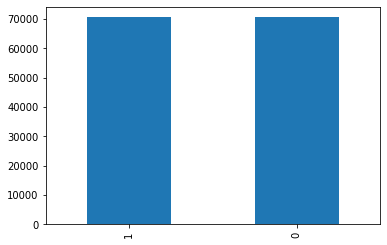

In [135]:
# observe that data has been balanced
pd.Series(os_train_y).value_counts().plot.bar()
plt.show()

In [136]:
os_train_X = pd.DataFrame(data=os_train_X)
os_train_y= pd.DataFrame(data=os_train_y)

In [137]:
print(os_train_y.shape)
print(os_train_X.shape)

(141132, 1)
(141132, 45)


In [138]:
os_train_y.columns

Index(['No-show'], dtype='object')

In [139]:
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_train_X))
print("Number of 'No-show' patients in oversampled data",len(os_train_y[os_train_y['No-show']==1]))
print("Number of non 'No-show' patients ",len(os_train_y[os_train_y['No-show']==0]))

print("Proportion of 'No-show' patients in oversampled data is",len(os_train_y[os_train_y['No-show']==1])/len(os_train_X))
print("Proportion of non 'No-show' patients in oversampled data is",len(os_train_y[os_train_y['No-show']==0])/len(os_train_X))


length of oversampled data is  141132
Number of 'No-show' patients in oversampled data 70566
Number of non 'No-show' patients  70566
Proportion of 'No-show' patients in oversampled data is 0.5
Proportion of non 'No-show' patients in oversampled data is 0.5


### 9. GBM with SMOTe

In [140]:
clf_GBM_smot = GradientBoostingClassifier(n_estimators=100,
                                       learning_rate=0.01,
                                       subsample=0.8, random_state=123)

In [141]:
clf_GBM_smot.fit(os_train_X, os_train_y)

GradientBoostingClassifier(learning_rate=0.01, random_state=123, subsample=0.8)

In [142]:
y_pred_train = clf_GBM_smot.predict(os_train_X)
y_pred_val = clf_GBM_smot.predict(X_val_final)

##### Evaluating the model performance

In [143]:
scores = get_metrics(os_train_y,y_pred_train,y_val,y_pred_val,"GBM_SMOTe",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8064    0.4840    0.6050     70566
           1     0.6314    0.8838    0.7366     70566

    accuracy                         0.6839    141132
   macro avg     0.7189    0.6839    0.6708    141132
weighted avg     0.7189    0.6839    0.6708    141132


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.9306    0.4779    0.6315     17642
           1     0.2940    0.8591    0.4380      4464

    accuracy                         0.5549     22106
   macro avg     0.6123    0.6685    0.5348     22106
weighted avg     0.8020    0.5549    0.5924     22106


               Confusion Matrix FOR TRAIN DATA
            
[[34157 36409]
 [ 8199 62367]]

               Confusion matrix FOR VALIDATION DATA
            
[[8431 9211]
 [ 629 3835]]


,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795422,0.016522,0.358010,0.031586,0.794354,0.014337,0.304762,0.027386
1,LogisticRegression_Balanced,0.663790,0.597368,0.321217,0.417783,0.659549,0.605511,0.319202,0.418033
2,DecisionTree,0.857703,0.366956,0.836675,0.510161,0.772053,0.188396,0.372619,0.250260
3,DecisionTree_BestParameters,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
4,DecisionTree_RandomizedSearch,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
5,Adaboost,0.772780,0.843181,0.465436,0.599789,0.672216,0.517473,0.312078,0.389348
6,Adaboost_BestParameters,0.857703,0.397200,0.795870,0.529926,0.773591,0.185708,0.376990,0.248837
7,GBM,0.799154,0.011817,0.647239,0.023211,0.797838,0.008065,0.467532,0.015856
8,GBM_SMOTe,0.683927,0.883811,0.631398,0.736580,0.554872,0.859095,0.293960,0.438035


### 10. XGBoost Classifier

In [144]:
from xgboost import XGBClassifier

In [145]:
clf_XGB = XGBClassifier(n_estimators=400, gamma=0.5,learning_rate=0.1,n_jobs=-1)
clf_XGB.fit(X_train_final, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [146]:
y_pred_train = clf_XGB.predict(X_train_final)
y_pred_val = clf_XGB.predict(X_val_final)

In [147]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"XGBoost",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8042    0.9964    0.8901     70566
           1     0.7452    0.0411    0.0779     17855

    accuracy                         0.8035     88421
   macro avg     0.7747    0.5188    0.4840     88421
weighted avg     0.7923    0.8035    0.7261     88421


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.8011    0.9949    0.8875     17642
           1     0.5408    0.0237    0.0455      4464

    accuracy                         0.7988     22106
   macro avg     0.6710    0.5093    0.4665     22106
weighted avg     0.7485    0.7988    0.7175     22106


               Confusion Matrix FOR TRAIN DATA
            
[[70315   251]
 [17121   734]]

               Confusion matrix FOR VALIDATION DATA
            
[[17552    90]
 [ 4358   106]]


,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795422,0.016522,0.358010,0.031586,0.794354,0.014337,0.304762,0.027386
1,LogisticRegression_Balanced,0.663790,0.597368,0.321217,0.417783,0.659549,0.605511,0.319202,0.418033
2,DecisionTree,0.857703,0.366956,0.836675,0.510161,0.772053,0.188396,0.372619,0.250260
3,DecisionTree_BestParameters,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
4,DecisionTree_RandomizedSearch,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
5,Adaboost,0.772780,0.843181,0.465436,0.599789,0.672216,0.517473,0.312078,0.389348
6,Adaboost_BestParameters,0.857703,0.397200,0.795870,0.529926,0.773591,0.185708,0.376990,0.248837
7,GBM,0.799154,0.011817,0.647239,0.023211,0.797838,0.008065,0.467532,0.015856
8,GBM_SMOTe,0.683927,0.883811,0.631398,0.736580,0.554872,0.859095,0.293960,0.438035
9,XGBoost,0.803531,0.041109,0.745178,0.077919,0.798788,0.023746,0.540816,0.045494


In [149]:
y_train.value_counts(normalize=True)

0    0.798068
1    0.201932
Name: No-show, dtype: float64

### 11. XGBoost with Grid Search CV

In [150]:
clf_XGB_grid = XGBClassifier()
 
# Use a grid over parameters of interest
param_grid = {
     'colsample_bytree': np.linspace(0.6, 0.8, 2),
     'n_estimators':[100, 200],
     'max_depth': [3, 4],
     'gamma': [0.2,0.3,0.4],
     'learning_rate': [0.001, 0.01, 0.1, 1, 10],
     'scale_pos_weight':[4]
}

In [151]:
# from sklearn.model_selection import RepeatedStratifiedKFold
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

CV_XGB = GridSearchCV(estimator=clf_XGB_grid, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')

In [152]:
%time CV_XGB.fit(X = X_train_final, y=y_train)

CPU times: user 22.2 s, sys: 640 ms, total: 22.9 s
Wall time: 23min 6s


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,
                  

In [153]:
# Find best model
best_xgb_model = CV_XGB.best_estimator_
print (CV_XGB.best_score_, CV_XGB.best_params_)

0.7310829707164922 {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'scale_pos_weight': 4}


In [154]:
best_xgb_model

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [155]:
y_pred_train=best_xgb_model.predict(X_train_final)
y_pred_val=best_xgb_model.predict(X_val_final)

In [156]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"XGBoost_BestParameters",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9303    0.5267    0.6726     70566
           1     0.3109    0.8440    0.4544     17855

    accuracy                         0.5908     88421
   macro avg     0.6206    0.6853    0.5635     88421
weighted avg     0.8052    0.5908    0.6285     88421


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.9226    0.5185    0.6639     17642
           1     0.3032    0.8282    0.4439      4464

    accuracy                         0.5810     22106
   macro avg     0.6129    0.6733    0.5539     22106
weighted avg     0.7976    0.5810    0.6195     22106


               Confusion Matrix FOR TRAIN DATA
            
[[37166 33400]
 [ 2786 15069]]

               Confusion matrix FOR VALIDATION DATA
            
[[9147 8495]
 [ 767 3697]]


,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795422,0.016522,0.358010,0.031586,0.794354,0.014337,0.304762,0.027386
1,LogisticRegression_Balanced,0.663790,0.597368,0.321217,0.417783,0.659549,0.605511,0.319202,0.418033
2,DecisionTree,0.857703,0.366956,0.836675,0.510161,0.772053,0.188396,0.372619,0.250260
3,DecisionTree_BestParameters,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
4,DecisionTree_RandomizedSearch,0.519345,0.919406,0.285610,0.435831,0.514430,0.919803,0.283524,0.433442
5,Adaboost,0.772780,0.843181,0.465436,0.599789,0.672216,0.517473,0.312078,0.389348
6,Adaboost_BestParameters,0.857703,0.397200,0.795870,0.529926,0.773591,0.185708,0.376990,0.248837
7,GBM,0.799154,0.011817,0.647239,0.023211,0.797838,0.008065,0.467532,0.015856
8,GBM_SMOTe,0.683927,0.883811,0.631398,0.736580,0.554872,0.859095,0.293960,0.438035
9,XGBoost,0.803531,0.041109,0.745178,0.077919,0.798788,0.023746,0.540816,0.045494
